# Part 0: Setting up

## Install pyspark

In [1]:
  # install java
  !apt-get update
  !apt-get install openjdk-8-jdk-headless -qq > /dev/null
  # install spark (change the version number if needed)
  !wget -q https://downloads.apache.org/spark/spark-3.4.1/spark-3.4.1-bin-hadoop3.tgz
  # unzip the spark file to the current folder
  !tar xf spark-3.4.1-bin-hadoop3.tgz

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:6 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [518 kB]
Get:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Get:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:10 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,078 kB]
Get:11 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,002 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [1,223 k

In [2]:
# set your spark folder to your system path environment.
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.1-bin-hadoop3"

In [3]:
!pip install findspark
import findspark
findspark.init()

## Create a SparkSession in Python

In [4]:
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local")\
          .appName("Analyze Movie")\
          .config("spark.some.config.option", "some-value")\
          .getOrCreate()

## Import library

In [142]:
from pyspark.sql.functions import split
from pyspark.sql.functions import regexp_extract, col
from pyspark.sql.functions import max
from pyspark.sql.functions import min
from pyspark.sql.functions import explode
from pyspark.sql.functions import when
from pyspark.sql.functions import rank
from pyspark.sql.functions import round
from pyspark.sql.functions import desc, asc
from pyspark.sql import Row
from pyspark.sql.functions import lit,isnan
import math


from pyspark.sql.window import Window

import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
import gc
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS

## Download data





In [6]:
!wget https://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip ml-1m.zip

--2023-10-04 11:54:34--  https://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘ml-1m.zip’

ml-1m.zip           100%[===================>]   5.64M  28.4MB/s    in 0.2s    

2023-10-04 11:54:35 (28.4 MB/s) - ‘ml-1m.zip’ saved [5917549/5917549]

Archive:  ml-1m.zip
   creating: ml-1m/
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         


# Part 1: Movies data

## Read movies.dat

Format: MovieID::Title (Year)::Genres

In [7]:
lines = spark.read.text("ml-1m/movies.dat")

In [8]:
# Split column
data = lines.select(split(lines.value, "::").alias("movie_data"))

In [9]:
data.show()

+--------------------+
|          movie_data|
+--------------------+
|[1, Toy Story (19...|
|[2, Jumanji (1995...|
|[3, Grumpier Old ...|
|[4, Waiting to Ex...|
|[5, Father of the...|
|[6, Heat (1995), ...|
|[7, Sabrina (1995...|
|[8, Tom and Huck ...|
|[9, Sudden Death ...|
|[10, GoldenEye (1...|
|[11, American Pre...|
|[12, Dracula: Dea...|
|[13, Balto (1995)...|
|[14, Nixon (1995)...|
|[15, Cutthroat Is...|
|[16, Casino (1995...|
|[17, Sense and Se...|
|[18, Four Rooms (...|
|[19, Ace Ventura:...|
|[20, Money Train ...|
+--------------------+
only showing top 20 rows



In [10]:
movie_df = data.select(
    data["movie_data"][0].cast("int").alias("MovieID"),
    data["movie_data"][1].alias("Title"),
    data["movie_data"][2].alias("Genres")
)

In [11]:
# create new TitleN column and Year Column, split Genres to list
movie_df = movie_df.withColumn("TitleN", regexp_extract("Title", r"^(.*?)\s*\((\d{4})\)$", 1))
movie_df = movie_df.withColumn("Year", regexp_extract("Title", r"^(.*?)\s*\((\d{4})\)$", 2))
movie_df = movie_df.withColumn("Genres", split("Genres", "\|"))

movie_df = movie_df.withColumn("Year", col("Year").cast("int"))
movie_df = movie_df.drop("Title")

In [12]:
movie_df.show()

+-------+--------------------+--------------------+----+
|MovieID|              Genres|              TitleN|Year|
+-------+--------------------+--------------------+----+
|      1|[Animation, Child...|           Toy Story|1995|
|      2|[Adventure, Child...|             Jumanji|1995|
|      3|   [Comedy, Romance]|    Grumpier Old Men|1995|
|      4|     [Comedy, Drama]|   Waiting to Exhale|1995|
|      5|            [Comedy]|Father of the Bri...|1995|
|      6|[Action, Crime, T...|                Heat|1995|
|      7|   [Comedy, Romance]|             Sabrina|1995|
|      8|[Adventure, Child...|        Tom and Huck|1995|
|      9|            [Action]|        Sudden Death|1995|
|     10|[Action, Adventur...|           GoldenEye|1995|
|     11|[Comedy, Drama, R...|American Presiden...|1995|
|     12|    [Comedy, Horror]|Dracula: Dead and...|1995|
|     13|[Animation, Child...|               Balto|1995|
|     14|             [Drama]|               Nixon|1995|
|     15|[Action, Adventur...| 

In [13]:
movie_df.printSchema()

root
 |-- MovieID: integer (nullable = true)
 |-- Genres: array (nullable = true)
 |    |-- element: string (containsNull = false)
 |-- TitleN: string (nullable = true)
 |-- Year: integer (nullable = true)



In [14]:
print("Number of rows: ",movie_df.count())

Number of rows:  3883


In [15]:
movie_df.select(max(col("MovieID"))).show()

+------------+
|max(MovieID)|
+------------+
|        3952|
+------------+



## Explore data

### Year column

#### Count Na in column

In [16]:
### Count Na in column
movie_df.filter(col("Year").isNull()).count()

0

#### Count unique year

In [17]:
### Count unique year
movie_df.select("Year").distinct().count()

81

##### Min Year

In [18]:
movie_df.select(min(("Year"))).show()

+---------+
|min(Year)|
+---------+
|     1919|
+---------+



#### Max Year

In [19]:
movie_df.select(max(("Year"))).show()

+---------+
|max(Year)|
+---------+
|     2000|
+---------+



#### Number movie each year

In [20]:
# Number movie each year
movie_df.groupBy('Year').count().sort(col("count").desc()).show()

+----+-----+
|Year|count|
+----+-----+
|1996|  345|
|1995|  342|
|1998|  337|
|1997|  315|
|1999|  283|
|1994|  257|
|1993|  165|
|2000|  156|
|1986|  104|
|1992|  102|
|1990|   77|
|1987|   71|
|1988|   69|
|1985|   65|
|1989|   60|
|1991|   60|
|1984|   60|
|1982|   50|
|1981|   43|
|1980|   41|
+----+-----+
only showing top 20 rows



### Genres column

####Show the list of distinct genres appearing in the dataset

In [21]:
lisGenre = movie_df.select(explode(col("Genres")).alias("Genre")).distinct()
lisGenre.toPandas()['Genre'].tolist()

['Crime',
 'Romance',
 'Thriller',
 'Adventure',
 "Children's",
 'Drama',
 'War',
 'Documentary',
 'Fantasy',
 'Mystery',
 'Musical',
 'Animation',
 'Film-Noir',
 'Horror',
 'Western',
 'Comedy',
 'Action',
 'Sci-Fi']

####Number of films per genre

In [22]:
movie_df.select(explode(col("Genres")).alias("Genre")).groupBy('Genre').count().sort(col("count").desc()).show()

+-----------+-----+
|      Genre|count|
+-----------+-----+
|      Drama| 1603|
|     Comedy| 1200|
|     Action|  503|
|   Thriller|  492|
|    Romance|  471|
|     Horror|  343|
|  Adventure|  283|
|     Sci-Fi|  276|
| Children's|  251|
|      Crime|  211|
|        War|  143|
|Documentary|  127|
|    Musical|  114|
|    Mystery|  106|
|  Animation|  105|
|    Fantasy|   68|
|    Western|   68|
|  Film-Noir|   44|
+-----------+-----+



### TitleN column

### Number of different movie titles

In [23]:
movie_df.select("TitleN").distinct().count()

3841

#### Longest and shortest titles

In [24]:
### Longest
from pyspark.sql.functions import length

title_df = movie_df.select("TitleN")
title_df = title_df.withColumn("LengthTitle", length("TitleN"))

In [25]:
max_len = title_df.select(max("LengthTitle")).first()[0]
title_df.where(col("LengthTitle") == max_len).show(truncate=False)

+---------------------------------------------------------------------------+-----------+
|TitleN                                                                     |LengthTitle|
+---------------------------------------------------------------------------+-----------+
|Those Who Love Me Can Take the Train (Ceux qui m'aiment prendront le train)|75         |
+---------------------------------------------------------------------------+-----------+



In [26]:
### Shortest
min_len = title_df.select(min("LengthTitle")).first()[0]
title_df.where(col("LengthTitle") == min_len).show(truncate=False)


+------+-----------+
|TitleN|LengthTitle|
+------+-----------+
|M     |1          |
+------+-----------+



In [27]:
del title_df
_ = gc.collect()

#### Most repeated titles

In [28]:
movie_df.groupBy("TitleN").count().orderBy(col("count").desc()).show(1)

+------+-----+
|TitleN|count|
+------+-----+
|Hamlet|    5|
+------+-----+
only showing top 1 row



-------------

## Read users.dat

Format: UserID::Gender::Age::Occupation::Zip-code


- Gender is denoted by a "M" for male and "F" for female
- Age is chosen from the following ranges:

	*  1:  "Under 18"
	* 18:  "18-24"
	* 25:  "25-34"
	* 35:  "35-44"
	* 45:  "45-49"
	* 50:  "50-55"
	* 56:  "56+"

- Occupation is chosen from the following choices:

	*  0:  "other" or not specified
	*  1:  "academic/educator"
	*  2:  "artist"
	*  3:  "clerical/admin"
	*  4:  "college/grad student"
	*  5:  "customer service"
	*  6:  "doctor/health care"
	*  7:  "executive/managerial"
	*  8:  "farmer"
	*  9:  "homemaker"
	* 10:  "K-12 student"
	* 11:  "lawyer"
	* 12:  "programmer"
	* 13:  "retired"
	* 14:  "sales/marketing"
	* 15:  "scientist"
	* 16:  "self-employed"
	* 17:  "technician/engineer"
	* 18:  "tradesman/craftsman"
	* 19:  "unemployed"
	* 20:  "writer"


In [29]:
lines = spark.read.text("ml-1m/users.dat")

In [30]:
# Split column
data = lines.select(split(lines.value, "::").alias("user_data"))

In [31]:
data.show()

+--------------------+
|           user_data|
+--------------------+
|[1, F, 1, 10, 48067]|
|[2, M, 56, 16, 70...|
|[3, M, 25, 15, 55...|
|[4, M, 45, 7, 02460]|
|[5, M, 25, 20, 55...|
|[6, F, 50, 9, 55117]|
|[7, M, 35, 1, 06810]|
|[8, M, 25, 12, 11...|
|[9, M, 25, 17, 61...|
|[10, F, 35, 1, 95...|
|[11, F, 25, 1, 04...|
|[12, M, 25, 12, 3...|
|[13, M, 45, 1, 93...|
|[14, M, 35, 0, 60...|
|[15, M, 25, 7, 22...|
|[16, F, 35, 0, 20...|
|[17, M, 50, 1, 95...|
|[18, F, 18, 3, 95...|
|[19, M, 1, 10, 48...|
|[20, M, 25, 14, 5...|
+--------------------+
only showing top 20 rows



In [32]:
user_df = data.select(
    data["user_data"][0].cast("int").alias("UserID"),
    data["user_data"][1].alias("Gender"),
    data["user_data"][2].cast("int").alias("Age"),
    data["user_data"][3].cast("int").alias("Occupation"),
    data["user_data"][4].alias("Zip-code")
)

In [33]:
user_df.show(10)

+------+------+---+----------+--------+
|UserID|Gender|Age|Occupation|Zip-code|
+------+------+---+----------+--------+
|     1|     F|  1|        10|   48067|
|     2|     M| 56|        16|   70072|
|     3|     M| 25|        15|   55117|
|     4|     M| 45|         7|   02460|
|     5|     M| 25|        20|   55455|
|     6|     F| 50|         9|   55117|
|     7|     M| 35|         1|   06810|
|     8|     M| 25|        12|   11413|
|     9|     M| 25|        17|   61614|
|    10|     F| 35|         1|   95370|
+------+------+---+----------+--------+
only showing top 10 rows



### Gender Column

#### Number per gender

In [34]:
gender_df = user_df.groupBy('Gender').count().toPandas()
gender_df

,Gender,count
0,F,1709
1,M,4331


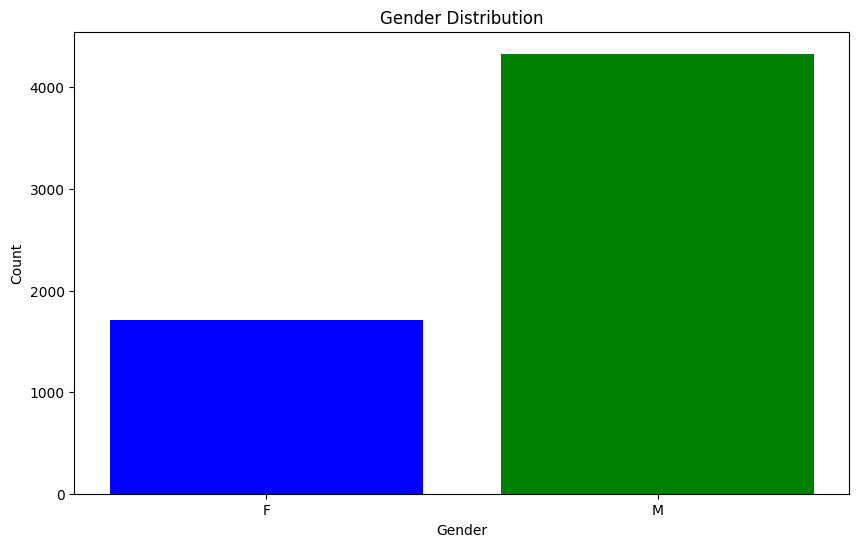

In [35]:
colors = ['blue', 'green']
plt.figure(figsize=(10, 6))
plt.bar(gender_df["Gender"], gender_df["count"], color = colors)
plt.xlabel("Gender")
plt.ylabel("Count")
plt.title("Gender Distribution")
plt.show()

In [36]:
del gender_df
_ = gc.collect()

#### Age column

#### Age distribution of users

In [37]:
age_df = user_df.groupBy('Age').count().toPandas()
age_df

,Age,count
0,1,222
1,35,1193
2,50,496
3,45,550
4,25,2096
5,56,380
6,18,1103


In [38]:
## convert age
map_age = {1: "Under 18",
          18: "18-24",
          25: "25-34",
          35: "35-44",
          45: "45-49",
          50: "50-55",
          56: "56+"}

age_df["Age"] = age_df["Age"].map(map_age)
age_df

,Age,count
0,Under 18,222
1,35-44,1193
2,50-55,496
3,45-49,550
4,25-34,2096
5,56+,380
6,18-24,1103


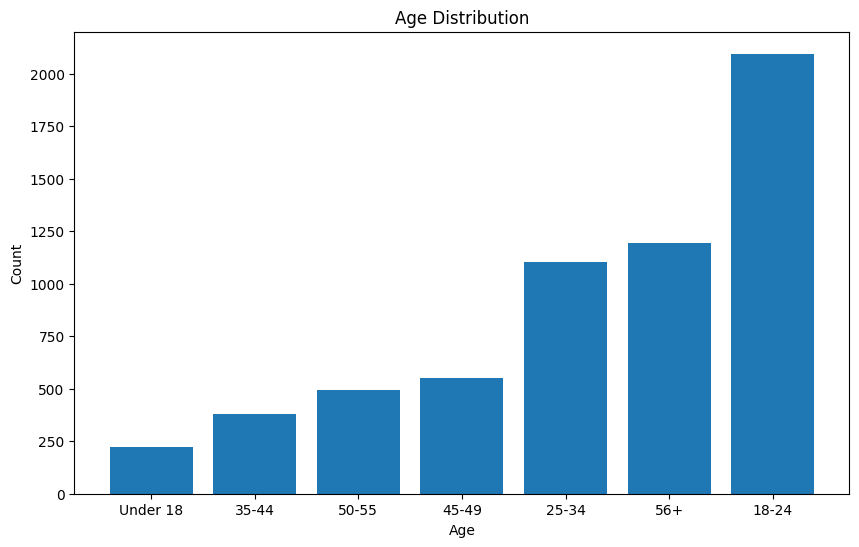

In [39]:
### draw chart
sns.color_palette("husl", 8)
colors = ['blue', 'green']
plt.figure(figsize=(10, 6))
plt.bar(age_df["Age"], age_df["count"].sort_values())
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Age Distribution")
plt.show()

In [40]:
del age_df
_ = gc.collect()

#### Occupation distribution of users

In [41]:
occupation_df = user_df.groupBy('Occupation').count().toPandas()
occupation_df

,Occupation,count
0,12,388
1,1,528
2,13,142
3,16,241
4,6,236
5,3,173
6,20,281
7,5,112
8,19,72
9,15,144


In [42]:
## convert age
map_occupation = {0: "other or not specified",
1: "academic/educator",
2: "artist",
3: "clerical/admin",
4: "college/grad student",
5: "customer service",
6: "doctor/health care",
7: "executive/managerial",
8: "farmer",
9: "homemaker",
10: "K-12 student",
11: "lawyer",
12: "programmer",
13: "retired",
14: "sales/marketing",
15: "scientist",
16: "self-employed",
17: "technician/engineer",
18: "tradesman/craftsman",
19: "unemployed",
20: "writer"}

occupation_df["Occupation"] = occupation_df["Occupation"].map(map_occupation)
occupation_df

,Occupation,count
0,programmer,388
1,academic/educator,528
2,retired,142
3,self-employed,241
4,doctor/health care,236
5,clerical/admin,173
6,writer,281
7,customer service,112
8,unemployed,72
9,scientist,144


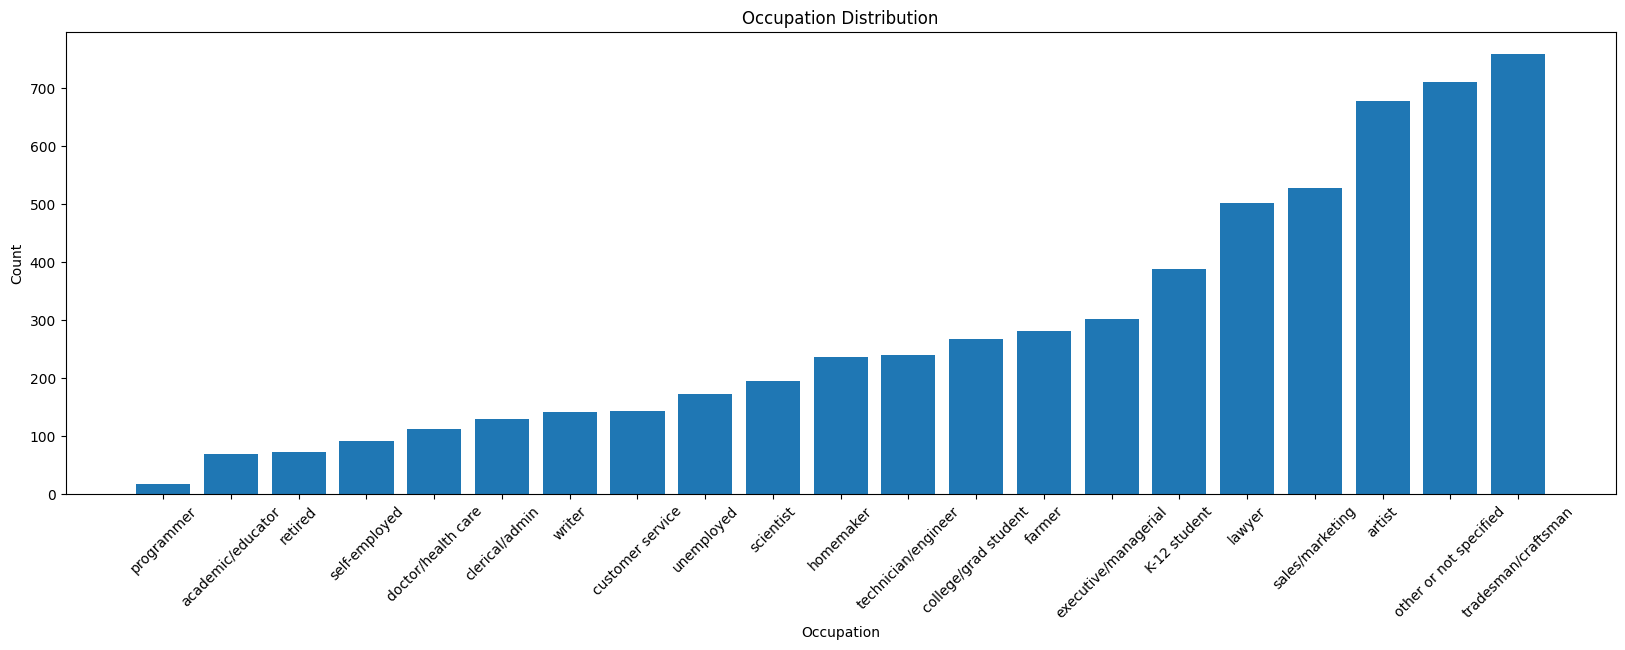

In [43]:
### draw chart
sns.color_palette("husl", 8)
plt.figure(figsize=(20, 6))
plt.bar(occupation_df["Occupation"], occupation_df["count"].sort_values())
plt.xticks(rotation = 45)
plt.xlabel("Occupation")
plt.ylabel("Count")
plt.title("Occupation Distribution")
plt.show()

In [44]:
del occupation_df
_ = gc.collect()

-------------

## Read ratings.dat

Format: UserID::MovieID::Rating::Timestamp
- UserIDs range between 1 and 6040
- MovieIDs range between 1 and 3952
- Ratings are made on a 5-star scale (whole-star ratings only)
- Timestamp is represented in seconds since the epoch as returned by time(2)
- Each user has at least 20 ratings
---



In [45]:
lines = spark.read.text("ml-1m/ratings.dat")

In [46]:
# Split column
data = lines.select(split(lines.value, "::").alias("rating_data"))

In [47]:
data.show()

+--------------------+
|         rating_data|
+--------------------+
|[1, 1193, 5, 9783...|
|[1, 661, 3, 97830...|
|[1, 914, 3, 97830...|
|[1, 3408, 4, 9783...|
|[1, 2355, 5, 9788...|
|[1, 1197, 3, 9783...|
|[1, 1287, 5, 9783...|
|[1, 2804, 5, 9783...|
|[1, 594, 4, 97830...|
|[1, 919, 4, 97830...|
|[1, 595, 5, 97882...|
|[1, 938, 4, 97830...|
|[1, 2398, 4, 9783...|
|[1, 2918, 4, 9783...|
|[1, 1035, 5, 9783...|
|[1, 2791, 4, 9783...|
|[1, 2687, 3, 9788...|
|[1, 2018, 4, 9783...|
|[1, 3105, 5, 9783...|
|[1, 2797, 4, 9783...|
+--------------------+
only showing top 20 rows



In [48]:
rating_df = data.select(
    data["rating_data"][0].cast("int").alias("UserID"),
    data["rating_data"][1].cast("int").alias("MovieID"),
    data["rating_data"][2].cast("int").alias("Rating"),
    data["rating_data"][3].cast("int").alias("Timestamp")
)

In [49]:
rating_df.show(10)

+------+-------+------+---------+
|UserID|MovieID|Rating|Timestamp|
+------+-------+------+---------+
|     1|   1193|     5|978300760|
|     1|    661|     3|978302109|
|     1|    914|     3|978301968|
|     1|   3408|     4|978300275|
|     1|   2355|     5|978824291|
|     1|   1197|     3|978302268|
|     1|   1287|     5|978302039|
|     1|   2804|     5|978300719|
|     1|    594|     4|978302268|
|     1|    919|     4|978301368|
+------+-------+------+---------+
only showing top 10 rows



In [50]:
rating_df.count()

1000209

### User Column

#### Top 10 Users rate the most movies

In [51]:
count_user = rating_df.groupBy("UserID").count().orderBy(col("count").desc()).limit(10)
count_user.show()

+------+-----+
|UserID|count|
+------+-----+
|  4169| 2314|
|  1680| 1850|
|  4277| 1743|
|  1941| 1595|
|  1181| 1521|
|   889| 1518|
|  3618| 1344|
|  2063| 1323|
|  1150| 1302|
|  1015| 1286|
+------+-----+



In [52]:
user_inf = count_user.join(user_df, on="UserID")
user_inf.show()

+------+-----+------+---+----------+--------+
|UserID|count|Gender|Age|Occupation|Zip-code|
+------+-----+------+---+----------+--------+
|   889| 1518|     M| 45|        20|   10024|
|  1015| 1286|     M| 35|         3|   11220|
|  1150| 1302|     F| 25|        20|   75226|
|  1181| 1521|     M| 35|         7|   20716|
|  1680| 1850|     M| 25|        20|   95380|
|  1941| 1595|     M| 35|        17|   94550|
|  2063| 1323|     M| 25|         4|   43138|
|  3618| 1344|     M| 56|        17|   22657|
|  4169| 2314|     M| 50|         0|   66048|
|  4277| 1743|     M| 35|        16|   98133|
+------+-----+------+---+----------+--------+



In [53]:
del user_inf, count_user
_ = gc.collect()

#### Top 10 movies with the most reviews

In [54]:
count_movie = rating_df.groupBy("MovieID").count().orderBy(col("count").desc()).limit(10)
count_movie.show()

+-------+-----+
|MovieID|count|
+-------+-----+
|   2858| 3428|
|    260| 2991|
|   1196| 2990|
|   1210| 2883|
|    480| 2672|
|   2028| 2653|
|    589| 2649|
|   2571| 2590|
|   1270| 2583|
|    593| 2578|
+-------+-----+



In [55]:
top_movie = count_movie.join(movie_df, on="MovieID")
top_movie = top_movie.orderBy(col("count").desc())
top_movie.show(truncate=False)

+-------+-----+-----------------------------------------+----------------------------------------------+----+
|MovieID|count|Genres                                   |TitleN                                        |Year|
+-------+-----+-----------------------------------------+----------------------------------------------+----+
|2858   |3428 |[Comedy, Drama]                          |American Beauty                               |1999|
|260    |2991 |[Action, Adventure, Fantasy, Sci-Fi]     |Star Wars: Episode IV - A New Hope            |1977|
|1196   |2990 |[Action, Adventure, Drama, Sci-Fi, War]  |Star Wars: Episode V - The Empire Strikes Back|1980|
|1210   |2883 |[Action, Adventure, Romance, Sci-Fi, War]|Star Wars: Episode VI - Return of the Jedi    |1983|
|480    |2672 |[Action, Adventure, Sci-Fi]              |Jurassic Park                                 |1993|
|2028   |2653 |[Action, Drama, War]                     |Saving Private Ryan                           |1998|
|589    |2

In [56]:
del count_movie
_ = gc.collect()

#### Get all movies with the highest ratings

In [57]:
from pyspark.sql.functions import mean

mean_rate = rating_df.groupBy("MovieID").agg(mean(col("Rating")).alias("MeanRating")).orderBy(col("MeanRating").desc())
mean_rate.show(5)

+-------+----------+
|MovieID|MeanRating|
+-------+----------+
|   3382|       5.0|
|   1830|       5.0|
|   3280|       5.0|
|    989|       5.0|
|   3656|       5.0|
+-------+----------+
only showing top 5 rows



We can see have many movies which are rated 5 stars. So we will get all 5 stars movie.

In [58]:
top_movie = mean_rate.filter(mean_rate["MeanRating"] == 5)
top_movie = top_movie.join(movie_df, on="MovieID")
print("Number of 5 starts movie: ", top_movie.count(), end="\n\n")
top_movie.show(truncate=False)

Number of 5 starts movie:  10

+-------+----------+------------------------+----------------------------------+----+
|MovieID|MeanRating|Genres                  |TitleN                            |Year|
+-------+----------+------------------------+----------------------------------+----+
|787    |5.0       |[Documentary]           |Gate of Heavenly Peace, The       |1995|
|3172   |5.0       |[Adventure]             |Ulysses (Ulisse)                  |1954|
|3607   |5.0       |[Comedy, Drama, Western]|One Little Indian                 |1973|
|989    |5.0       |[Drama]                 |Schlafes Bruder (Brother of Sleep)|1995|
|3382   |5.0       |[Drama]                 |Song of Freedom                   |1936|
|3280   |5.0       |[Horror]                |Baby, The                         |1973|
|3656   |5.0       |[Crime]                 |Lured                             |1947|
|3233   |5.0       |[Comedy]                |Smashing Time                     |1967|
|1830   |5.0       |[Co

In [59]:
del top_movie, mean_rate
_ = gc.collect()

#### Ask other questions that make sense of the data

We will assign rating points as follows:
- Favorites: 4-5
- Okay: 3-4
- Not good: 0-3

#### Genres with the highest and lowest ratings

In [60]:
rating_df[["MovieID", "Rating"]].show()

+-------+------+
|MovieID|Rating|
+-------+------+
|   1193|     5|
|    661|     3|
|    914|     3|
|   3408|     4|
|   2355|     5|
|   1197|     3|
|   1287|     5|
|   2804|     5|
|    594|     4|
|    919|     4|
|    595|     5|
|    938|     4|
|   2398|     4|
|   2918|     4|
|   1035|     5|
|   2791|     4|
|   2687|     3|
|   2018|     4|
|   3105|     5|
|   2797|     4|
+-------+------+
only showing top 20 rows



In [61]:
explode_genre = movie_df.select(explode(col("Genres")).alias("Genre"), col("MovieID"))
new_rating = explode_genre.join(rating_df[["UserID","MovieID", "Rating"]], on="MovieID")
new_rating.show()

+-------+----------+------+------+
|MovieID|     Genre|UserID|Rating|
+-------+----------+------+------+
|   1193|     Drama|     1|     5|
|    661|   Musical|     1|     3|
|    661|Children's|     1|     3|
|    661| Animation|     1|     3|
|    914|   Romance|     1|     3|
|    914|   Musical|     1|     3|
|   3408|     Drama|     1|     4|
|   2355|    Comedy|     1|     5|
|   2355|Children's|     1|     5|
|   2355| Animation|     1|     5|
|   1197|   Romance|     1|     3|
|   1197|    Comedy|     1|     3|
|   1197| Adventure|     1|     3|
|   1197|    Action|     1|     3|
|   1287|     Drama|     1|     5|
|   1287| Adventure|     1|     5|
|   1287|    Action|     1|     5|
|   2804|     Drama|     1|     5|
|   2804|    Comedy|     1|     5|
|    594|   Musical|     1|     4|
+-------+----------+------+------+
only showing top 20 rows



In [62]:
genre_rating = new_rating.groupBy("Genre").\
              agg(mean(col("Rating")).alias("MeanRating")).\
              orderBy(col("MeanRating").desc()).toPandas()

genre_rating["MeanRating"] = genre_rating["MeanRating"].round(2)
genre_rating.head()

,Genre,MeanRating
0,Film-Noir,4.08
1,Documentary,3.93
2,War,3.89
3,Drama,3.77
4,Crime,3.71


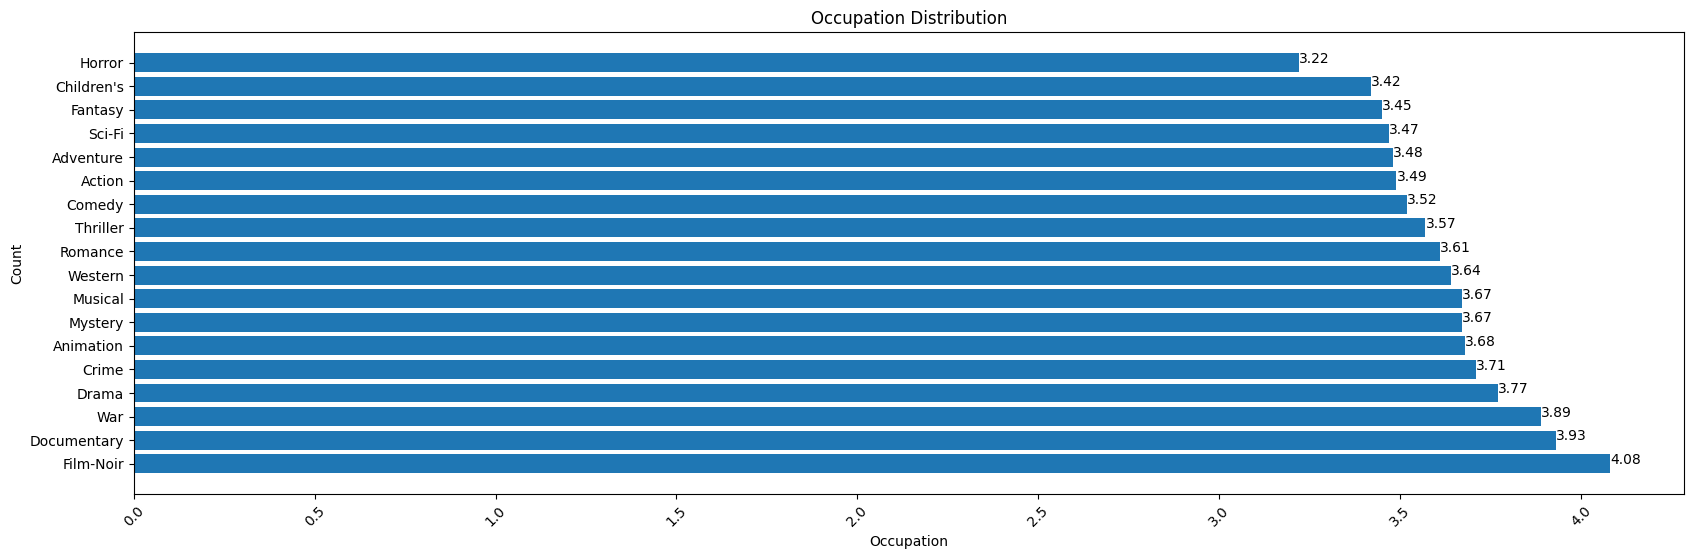

In [63]:
sns.color_palette("husl", 8)
plt.figure(figsize=(20, 6))
plt.barh(genre_rating["Genre"], genre_rating["MeanRating"])

for i in range(len(genre_rating["Genre"])):
    plt.text(genre_rating["MeanRating"][i], i, genre_rating["MeanRating"][i], ha = 'left')

plt.xticks(rotation = 45)
plt.xlabel("Occupation")
plt.ylabel("Count")
plt.title("Occupation Distribution")
plt.show()

In [64]:
del explode_genre, genre_rating
_ = gc.collect()

#### For each age group, what is their favorite movie genre?

In [65]:
rating_w_age = new_rating.join(user_df[["UserID", "Age"]], on="UserID")
rating_w_age = rating_w_age.drop("MovieID")
rating_w_age.show()

+------+----------+------+---+
|UserID|     Genre|Rating|Age|
+------+----------+------+---+
|     1|     Drama|     5|  1|
|     1|   Musical|     3|  1|
|     1|Children's|     3|  1|
|     1| Animation|     3|  1|
|     1|   Romance|     3|  1|
|     1|   Musical|     3|  1|
|     1|     Drama|     4|  1|
|     1|    Comedy|     5|  1|
|     1|Children's|     5|  1|
|     1| Animation|     5|  1|
|     1|   Romance|     3|  1|
|     1|    Comedy|     3|  1|
|     1| Adventure|     3|  1|
|     1|    Action|     3|  1|
|     1|     Drama|     5|  1|
|     1| Adventure|     5|  1|
|     1|    Action|     5|  1|
|     1|     Drama|     5|  1|
|     1|    Comedy|     5|  1|
|     1|   Musical|     4|  1|
+------+----------+------+---+
only showing top 20 rows



In [66]:
rating_genre_age = rating_w_age.groupBy(["Age", "Genre"]).agg(mean(col("Rating")).alias("MeanRating")).orderBy(asc("Age"), desc("MeanRating"))

# Round MeanRating column
rating_genre_age = rating_genre_age.withColumn("MeanRating", round(col("MeanRating"), 2))

# Using  window and rank() function to rank the genres by avg of Rating
windowSpec = Window.partitionBy("Age").orderBy(col("MeanRating").desc())

# Add Rank column to rank genres in each age
rating_genre_age = rating_genre_age.withColumn("Rank", rank().over(windowSpec))

# Choose 5 genres top in each age
top_genres_by_age = rating_genre_age.filter(col("Rank") <= 5).orderBy("Age", "Rank")

top_genres_by_age.show()

+---+-----------+----------+----+
|Age|      Genre|MeanRating|Rank|
+---+-----------+----------+----+
|  1|  Film-Noir|      4.15|   1|
|  1|        War|       3.9|   2|
|  1|      Drama|      3.79|   3|
|  1|Documentary|      3.73|   4|
|  1|      Crime|      3.71|   5|
| 18|  Film-Noir|       4.0|   1|
| 18|Documentary|      3.87|   2|
| 18|        War|      3.85|   3|
| 18|      Drama|      3.72|   4|
| 18|      Crime|      3.67|   5|
| 25|  Film-Noir|      4.06|   1|
| 25|Documentary|      3.95|   2|
| 25|        War|      3.84|   3|
| 25|      Drama|      3.73|   4|
| 25|  Animation|       3.7|   5|
| 35|  Film-Noir|      4.06|   1|
| 35|Documentary|      3.95|   2|
| 35|        War|       3.9|   3|
| 35|      Drama|      3.78|   4|
| 35|  Animation|      3.74|   5|
+---+-----------+----------+----+
only showing top 20 rows



In [67]:
top_genres_by_age.show()

+---+-----------+----------+----+
|Age|      Genre|MeanRating|Rank|
+---+-----------+----------+----+
|  1|  Film-Noir|      4.15|   1|
|  1|        War|       3.9|   2|
|  1|      Drama|      3.79|   3|
|  1|Documentary|      3.73|   4|
|  1|      Crime|      3.71|   5|
| 18|  Film-Noir|       4.0|   1|
| 18|Documentary|      3.87|   2|
| 18|        War|      3.85|   3|
| 18|      Drama|      3.72|   4|
| 18|      Crime|      3.67|   5|
| 25|  Film-Noir|      4.06|   1|
| 25|Documentary|      3.95|   2|
| 25|        War|      3.84|   3|
| 25|      Drama|      3.73|   4|
| 25|  Animation|       3.7|   5|
| 35|  Film-Noir|      4.06|   1|
| 35|Documentary|      3.95|   2|
| 35|        War|       3.9|   3|
| 35|      Drama|      3.78|   4|
| 35|  Animation|      3.74|   5|
+---+-----------+----------+----+
only showing top 20 rows



In [68]:
map_age = {1: "Under 18",
          18: "18-24",
          25: "25-34",
          35: "35-44",
          45: "45-49",
          50: "50-55",
          56: "56+"}

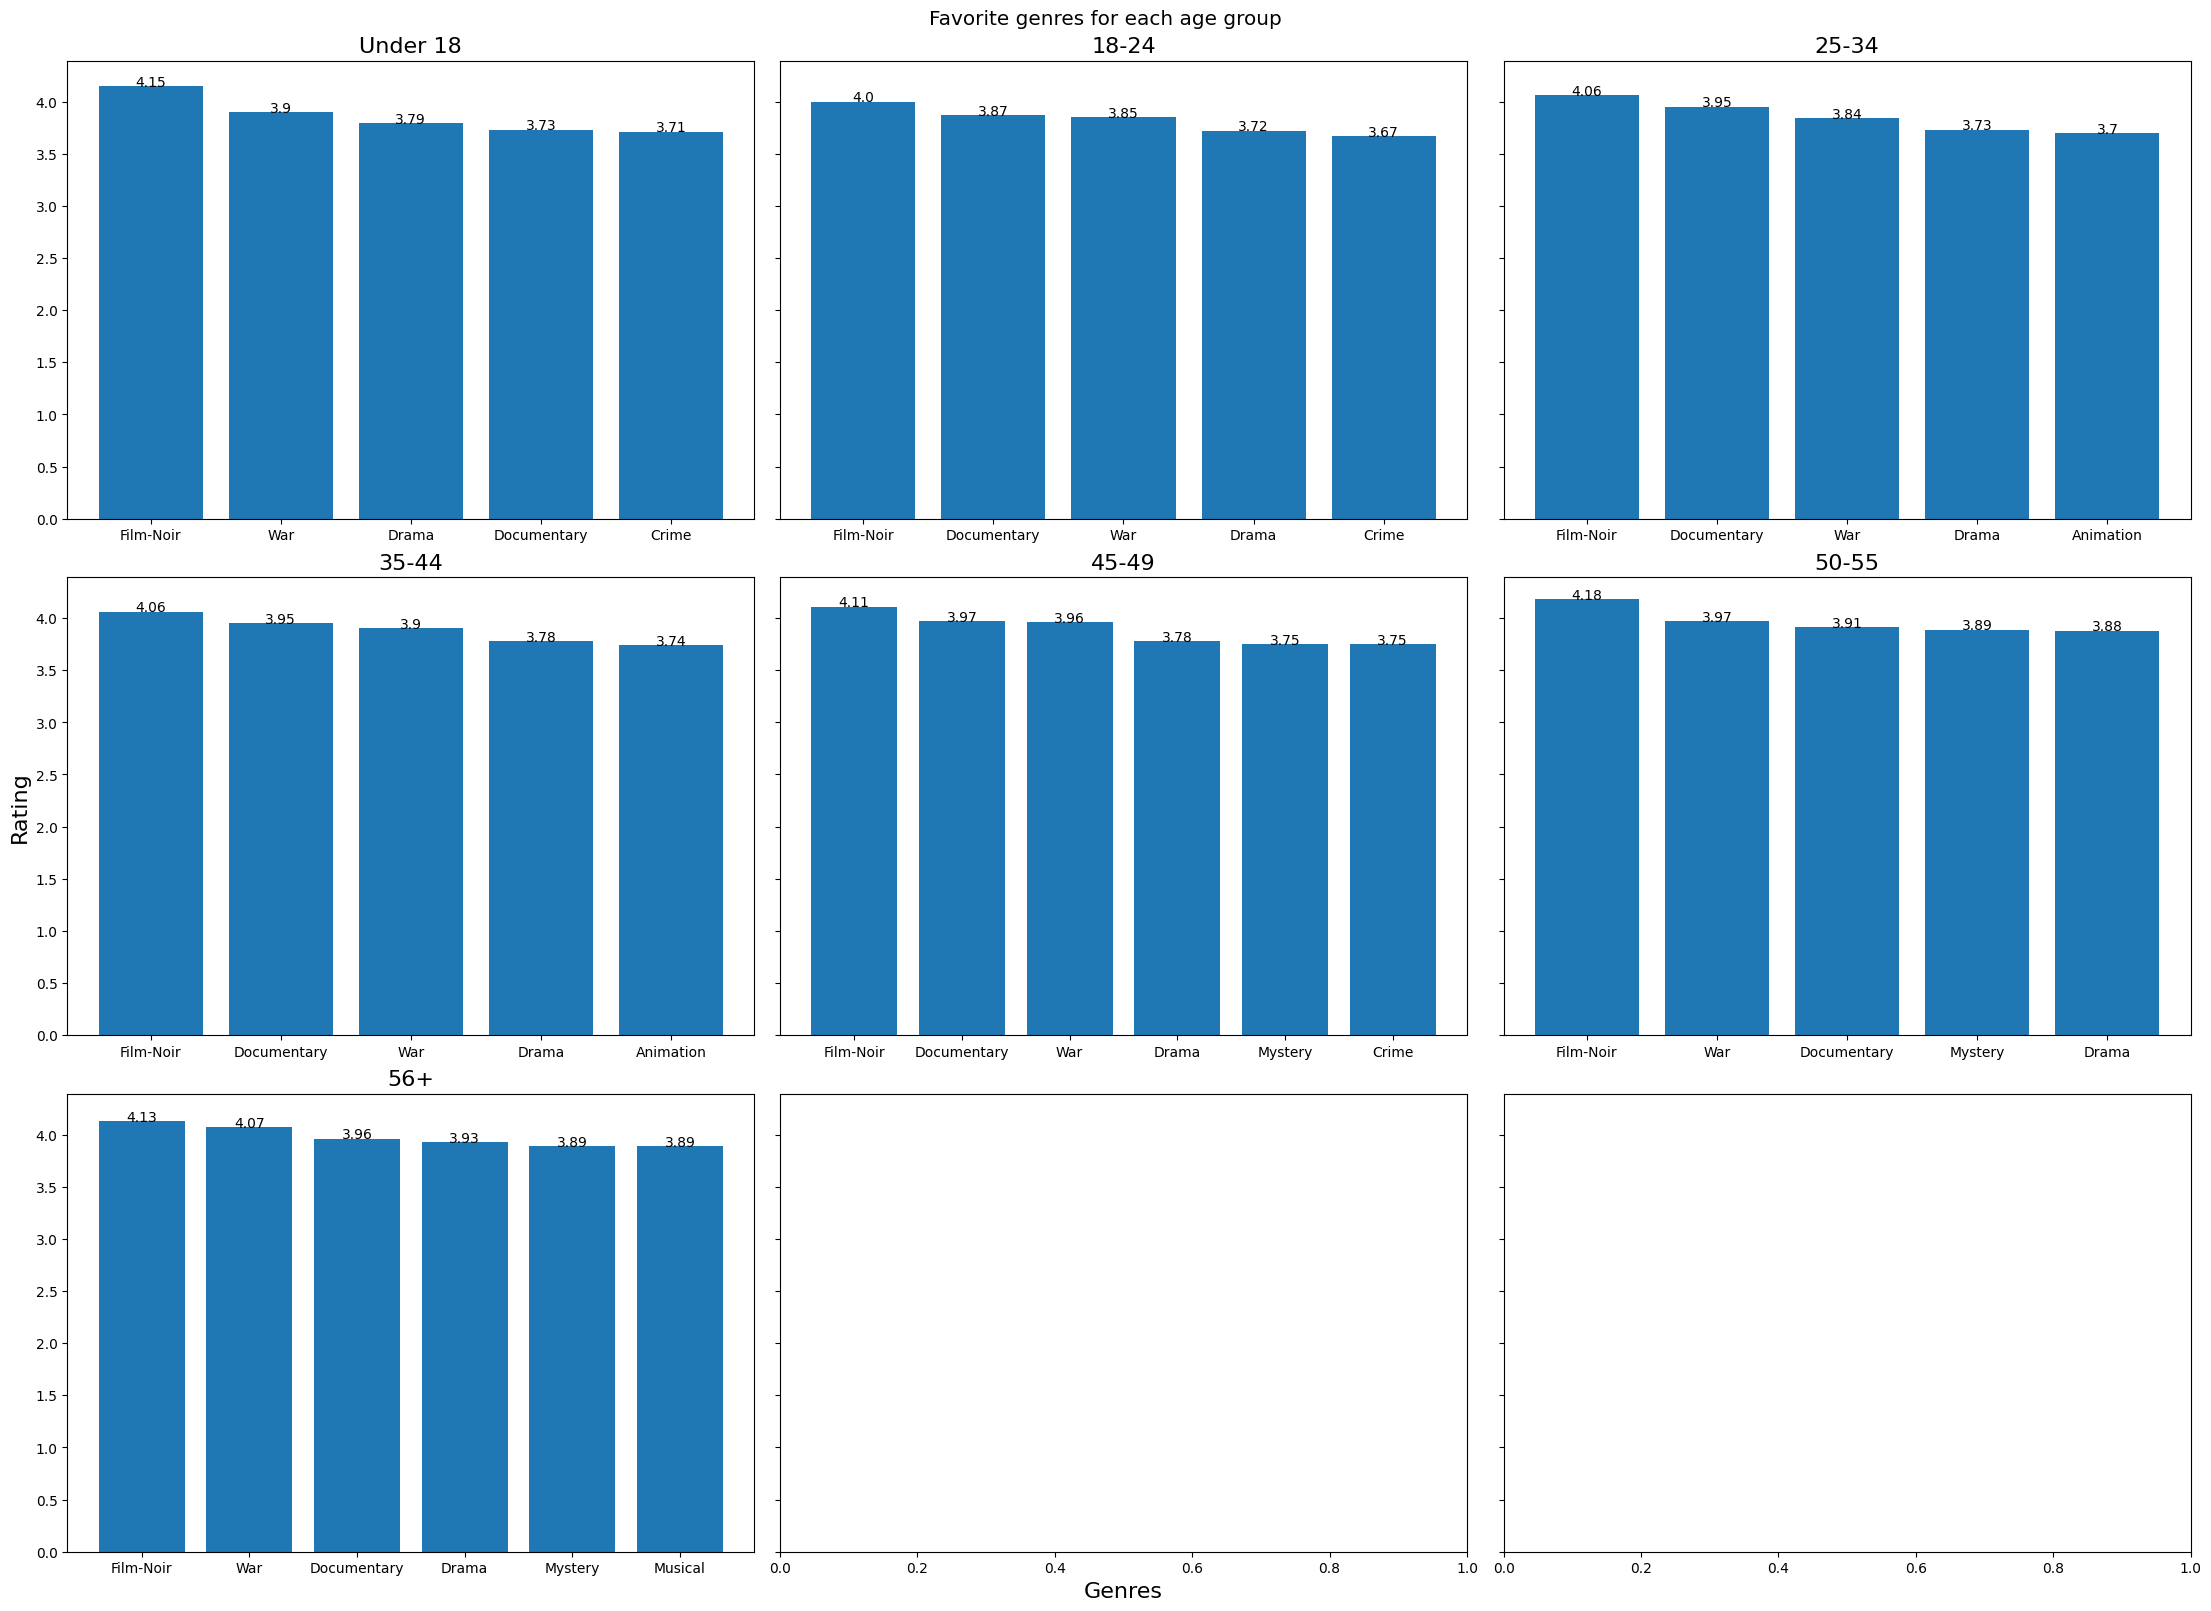

In [69]:
fig = plt.figure(constrained_layout=True, figsize=(22, 16))
fig.suptitle("Favorite genres for each age group", fontsize='x-large')

axs = fig.subplots(3, 3, sharey=True)

for i, key in enumerate(map_age):
  temp_df = top_genres_by_age.filter(col("Age") == key).drop("Age", "Rank").toPandas()
  nrow = i//3
  ncol = i%3
  axs[nrow, ncol].bar(temp_df["Genre"], temp_df["MeanRating"])
  axs[nrow, ncol].set_title(map_age[key], fontsize=16)
  for i in range(len(temp_df["Genre"])):
      axs[nrow, ncol].text( i, temp_df["MeanRating"][i], temp_df["MeanRating"][i], ha = 'center')


axs[1,0].set_ylabel('Rating', fontsize=16)
axs[2,1].set_xlabel('Genres', fontsize=16)

plt.show()

In [70]:
del top_genres_by_age
_ = gc.collect()

#### How are scores distributed according to age?

In [71]:
rating_dis_age = rating_w_age.groupBy(["Age","Rating"]).count().orderBy("Age","Rating")
rating_dis_age.show(5)

+---+------+-----+
|Age|Rating|count|
+---+------+-----+
|  1|     1| 4831|
|  1|     2| 6682|
|  1|     3|13905|
|  1|     4|18927|
|  1|     5|14475|
+---+------+-----+
only showing top 5 rows



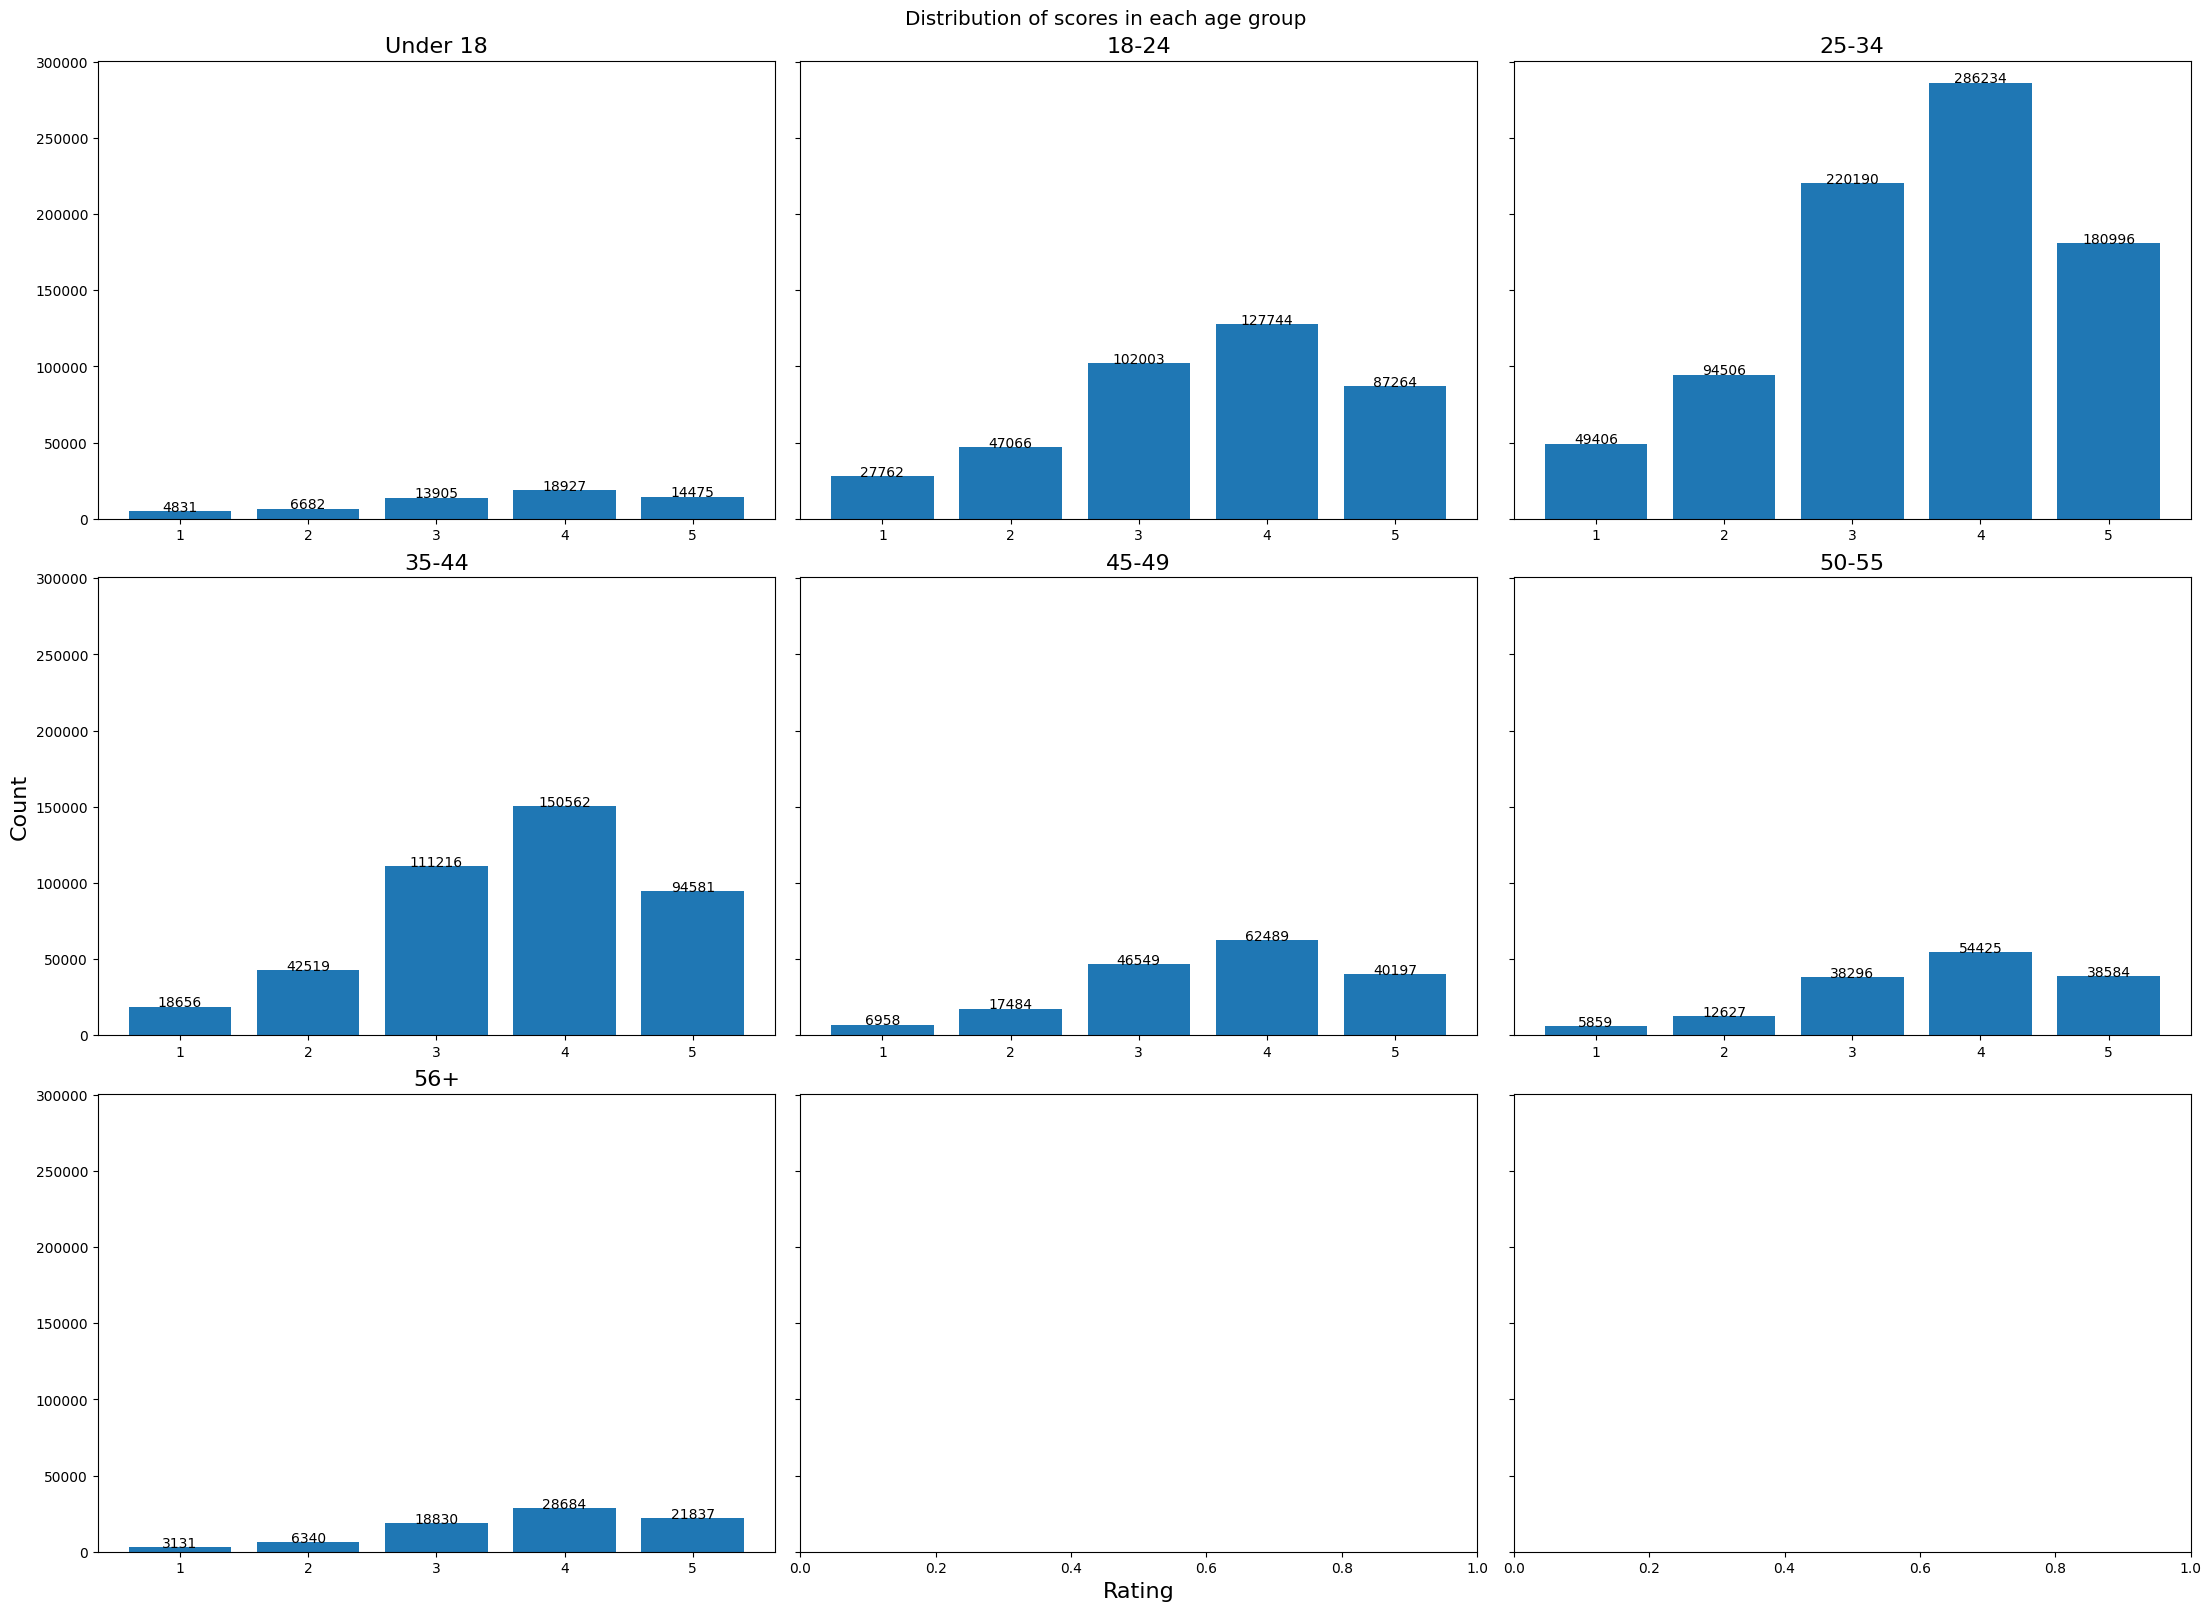

In [72]:
fig = plt.figure(constrained_layout=True, figsize=(22, 16))
fig.suptitle("Distribution of scores in each age group", fontsize='x-large')

axs = fig.subplots(3, 3, sharey=True)

for i, key in enumerate(map_age):
  temp_df = rating_dis_age.filter(col("Age") == key).drop("Age").toPandas()
  nrow = i//3
  ncol = i%3
  axs[nrow, ncol].bar(temp_df["Rating"], temp_df["count"])
  axs[nrow, ncol].set_title(map_age[key], fontsize=16)
  for i in range(len(temp_df["Rating"])):
      axs[nrow, ncol].text( i + 1, temp_df["count"][i], temp_df["count"][i], ha = 'center')


axs[1,0].set_ylabel('Count', fontsize=16)
axs[2,1].set_xlabel('Rating', fontsize=16)

plt.show()

In [73]:
del rating_dis_age, rating_w_age
_ = gc.collect()

# Recommend movies for users

### An example explains how to do it

Suppose we have ratings data stored using Numpy array
In this data:
- Each column corresponds to one movie
- Each line corresponds to a user, and indicates this user how many points for each movie (scale 1-5)

In [74]:
ratings = np.array([
    [5, 4, np.nan, 1, np.nan],
    [np.nan, 4, 4, 2, np.nan],
    [3, np.nan, np.nan, 5, np.nan],
    [np.nan, 3, 4, 4, np.nan]
])

ratings

array([[ 5.,  4., nan,  1., nan],
       [nan,  4.,  4.,  2., nan],
       [ 3., nan, nan,  5., nan],
       [nan,  3.,  4.,  4., nan]])

For simplicity, here we only focus on working for the first user.

In [75]:
# Calculate the weight representing similarities between the first user and all users
r0 = ratings[0]
a = np.abs(ratings - r0)
a = np.nanmean(a, axis=1) # Ignore nan
w = 1 / (a + 0.001) # Add 0.001 to avoid dividing by 0
w

array([1.00000000e+03, 1.99600798e+00, 3.33222259e-01, 4.99750125e-01])

In [76]:
# Because there are movies that don't have any reviews, we need to exclude these movies
mask = np.nansum(ratings, axis = 0) != 0
index = (mask) & ( np.isnan(r0))
index

array([False, False,  True, False, False])

In [77]:
# Get the columns corresponding to the movies
# that the first user has not yet scored
a = ratings[:, index]
a

array([[nan],
       [ 4.],
       [nan],
       [ 4.]])

In [78]:
# Calculate the normalized weight matrix
# has the same shape as the result above
# (the sum of the columns will be 1)
normalized_w = ~np.isnan(a) * w.reshape(-1, 1)
normalized_w = normalized_w / normalized_w.sum(axis=0)
normalized_w

array([[0.        ],
       [0.79976019],
       [0.        ],
       [0.20023981]])

In [79]:
# Multiply the rating with the normalized weight and then add it together
# will give a prediction score to the first user
np.nansum(a * normalized_w, axis=0)
# Thus, we can recommend to the first user a movie with a high prediction score.

array([4.])

## Using Numpy

### Preprocessing

In [80]:
### Convert to numpy array
rating_pdf = rating_df.toPandas()
raw_rating = rating_pdf.to_numpy()

### Delete column TimeStamp
raw_rating = raw_rating[:, :3]
del rating_pdf
_ = gc.collect()

To build a recommendation system, first, from the initial data which is the array `raw_rating`, we will need to create an array `ratings` including number-of-users in rows and number-of-movies in columns, `ratings[i, j]` indicates how many points the user with id i has given the movie with id j. If not, the value will be `nan`. Because Python indexes from 0, we also need to adjust the id of the user and movie to start at 0 (instead of 1).

In [81]:
count_user = len(np.unique(raw_rating[:,0]))
count_movie = len(np.unique(raw_rating[:,1]))
print(count_user, count_movie)

# number_user = len(np.unique(raw_rating[:,0]))
number_user = raw_rating[:,0].max()
# number_movie = len(np.unique(raw_rating[:,1]))
number_movie = raw_rating[:,1].max()

print(number_user, number_movie)

6040 3706
6040 3952


In [82]:
## Create new ratings
ratings = np.full((number_user, number_movie), fill_value = np.nan)
ratings[raw_rating[:, 0] - 1, raw_rating[:, 1] - 1] = raw_rating[:, 2]

Now we will make predictions for all users in the data. However, performing a prediction loop for each user would take a lot of time, so we will perform predictions for all users. But each user has different unrated movies, so to calculate the same for everyone, we will make predictions for even rated movies.
If you try it, you will see that it is still impossible to do it with all users at the same time, because the intermediate result arrays will be very large in size and will be reported as not having enough memory. Instead we will browse a group of users (called a batch).

In [83]:
batch_size = 16
filled_ratings = np.empty_like(ratings)

You can run the cell below by uncommenting it. But the running time of this method is quite long. So to save time we will save the results to a csv file and call it for future runs.

In [84]:
# num_batch = 0
# for batch in range(0, ratings.shape[0], batch_size):
#   start = batch
#   end = batch + batch_size if batch + batch_size < ratings.shape[0] else ratings.shape[0]

#   # Get batch of users
#   n_users = ratings[start:end]
#   n_users = np.repeat(n_users[:,np.newaxis,:], 1, axis = 1)
#   temp = np.abs(ratings - n_users)
#   temp = np.nanmean(temp, axis = 2)
#   similarities = 1 / (temp + 0.001)

#   mask = np.isnan(similarities)
#   similarities[mask] = 0

#   weights = np.repeat(similarities[:,:,np.newaxis],number_movie, axis = 2)
#   mask = np.isnan(ratings)
#   weights[:,mask] = 0
#   sum_similarity = weights.sum(axis=1)
#   sum_similarity = np.repeat(sum_similarity[:,np.newaxis,:],1, axis = 1)
#   weights = weights / sum_similarity
#   filled_ratings[start:end] = np.nansum(ratings * weights, axis = 1)

#   # print batch info
#   num_batch = num_batch + 1
#   if num_batch % 100 == 0:
#     print("Batch: "+str(num_batch)+". End user of batch: "+str(end))

<ipython-input-84-746d662990e8>:10: RuntimeWarning: Mean of empty slice
  temp = np.nanmean(temp, axis = 2)
<ipython-input-84-746d662990e8>:21: RuntimeWarning: invalid value encountered in divide
  weights = weights / sum_similarity


Batch: 100. End user of batch: 1600
Batch: 200. End user of batch: 3200
Batch: 300. End user of batch: 4800


In [161]:
# # Save to file
# np.savetxt("filled_df1.csv", filled_ratings, delimiter=',')

In [171]:
## Load
filled_ratings = np.loadtxt('filled_df1.csv', delimiter=',', dtype=np.float64)
filled_ratings.shape

(6040, 3952)

In [172]:
filled_ratings[0,:]

array([4.79799318, 3.78608505, 3.00707995, ..., 3.5098596 , 3.99473673,
       3.99264987])

### Prediction for UserID=1

In [89]:
## Prediction for UserID=1
# Get MovieID
user1_nfill = np.where(np.isnan(ratings[0, :]))
user1_nfill

(array([   1,    2,    3, ..., 3949, 3950, 3951]),)

In [90]:
#Get rating
user1_pre = filled_ratings[0,user1_nfill]

In [91]:
user1_pre

array([[3.78608505, 3.00707995, 2.9625424 , ..., 3.5098596 , 3.99473673,
        3.99264987]])

In [136]:
pre_df = pd.DataFrame({"MovieID" :user1_nfill[0]+1, "prediction":user1_pre[0]})
pre_df = pre_df.sort_values(["prediction", "MovieID"], ascending=False)
pre_df.head()

,MovieID,prediction
3827,3881,5.0
3602,3656,5.0
3553,3607,5.0
3329,3382,5.0
3180,3233,5.0


In [137]:
pre_df.shape

(3899, 2)

###Movie recommendation for UserID=1

In [138]:
recommend1 = pre_df[pre_df["prediction"] >=4]
recommend1.shape

(657, 2)

## Using Alternating Least Squares

In [93]:
rating_df = rating_df.drop("Timestamp")

In [94]:
train_data, test_data = rating_df.randomSplit([0.9, 0.1])

In [104]:
als = ALS(maxIter=15, regParam=0.01, userCol="UserID", itemCol="MovieID", ratingCol="Rating")

#Fitting the model on the train_data
model = als.fit(train_data)

In [105]:
# Make predictions on the test set
predictions = model.transform(test_data)

#Displaying predictions calculated by the model
predictions.show()

+------+-------+------+----------+
|UserID|MovieID|Rating|prediction|
+------+-------+------+----------+
|     1|   2797|     4| 3.9663906|
|     3|   2871|     4|  4.111898|
|     2|   2236|     5|  4.069309|
|     2|   3071|     4| 3.8847709|
|     1|   1961|     5|  4.484202|
|     2|   1244|     3|  2.993335|
|     3|   1615|     5|  3.963407|
|     2|   2571|     4| 3.8782337|
|     3|   1136|     5|  4.424986|
|     2|   1597|     3| 3.4934094|
|     2|   3468|     5|  3.881561|
|     3|   1379|     4| 3.7710097|
|     2|   1096|     4| 4.2381253|
|     3|    648|     3| 4.3024864|
|     2|    356|     5|  4.667208|
|     3|   2858|     4|  3.559215|
|     4|    480|     4| 2.5038528|
|     2|   1610|     5| 4.1247816|
|     2|   1784|     5|  4.019994|
|     1|   1836|     5| 2.5999072|
+------+-------+------+----------+
only showing top 20 rows



In [106]:
#Printing and calculating RMSE
evaluator = RegressionEvaluator(metricName="rmse", labelCol="Rating",predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = nan


The cause may be due to:
Missing data: One or more values ​​in the test or prediction data set may be missing (null or unknown).

### Prediction for UserID=1

In [107]:
## Prediction for UserID=1
# Create pyspark df for userID=1
lis_movie = (user1_nfill[0] + 1).tolist()
rdd = spark.sparkContext.parallelize(lis_movie)

# Convert the RDD into a DataFrame
movie_nf_df = rdd.map(lambda x: Row(MovieID=x)).toDF()

# Add UserID column
movie_nf_df = movie_nf_df.withColumn("UserID", lit(1))

movie_nf_df.show(5)

+-------+------+
|MovieID|UserID|
+-------+------+
|      2|     1|
|      3|     1|
|      4|     1|
|      5|     1|
|      6|     1|
+-------+------+
only showing top 5 rows



In [125]:
user1_pre2 = model.transform(movie_nf_df)
user1_pre2 = user1_pre2.where(~isnan("prediction"))
user1_pre2.show(5)

+-------+------+----------+
|MovieID|UserID|prediction|
+-------+------+----------+
|      2|     1| 3.2906842|
|      3|     1| 3.7604756|
|      4|     1| 3.0622725|
|      5|     1|  3.997052|
|      6|     1|  4.376733|
+-------+------+----------+
only showing top 5 rows



In [126]:
## Limit the score to between 1-5
user1_pre2 = user1_pre2.withColumn('prediction', when(col('prediction') > 5, 5)
.when(col("prediction")<1, 1)
.otherwise(col('prediction')))

user1_pre2 = user1_pre2.orderBy(col("prediction").desc(), col("MovieID").desc())
user1_pre2.show(5)

+-------+------+----------+
|MovieID|UserID|prediction|
+-------+------+----------+
|   3777|     1|       5.0|
|   3761|     1|       5.0|
|   3711|     1|       5.0|
|   3636|     1|       5.0|
|   3587|     1|       5.0|
+-------+------+----------+
only showing top 5 rows



In [124]:
user1_pre2.count()

3643

### Movie recommendation for UserID=1

In [134]:
recommend2 = user1_pre2.where(col("prediction")>=4).select("MovieID","prediction")
recommend2 = recommend2.toPandas()
recommend2.head()

,MovieID,prediction
0,3777,5.0
1,3761,5.0
2,3711,5.0
3,3636,5.0
4,3587,5.0


In [135]:
recommend2.shape

(564, 2)

## Comparison between two methods

First we see the number of recommended movies:
+ ALS: 564
+ Numpy: 657

Now we will find the number of movies that are recommended in both methods. And the predicted scores are different in these movies of the two methods.

In [154]:
diff = 0
count = 0
lis = []
for row1 in recommend1.values:
  for row2 in recommend2.values:
    if row1[0] == row2[0]:
      lis.append(int(row1[0]))
      count = count + 1
      diff += abs(row1[1] - row2[1])

print(f"Number of movies that are recommended in both methods: {count}")
print(f"The predicted scores are different in these movies of the two methods: {diff}")
print(f"Average of movies recommended by both different methods: {diff/count} points")

Number of movies that are recommended in both methods: 174
The predicted scores are different in these movies of the two methods: 55.18645786106998
Average of movies recommended by both different methods: 0.31716355092568954 points


In [157]:
lis[:10]

[3881, 3233, 3172, 787, 811, 1178, 3777, 937, 3487, 2620]

We see that there are 174 movies in the suggested list of both methods. And there is not much difference in prediction scores in both methods. We can prioritize recommending these movies first.

#<p style="background-color:#682F2F; font-family:newtimeroman; color:#FFF9ED; font-size:150%; text-align:center; border-radius:10px 10px; padding: 15px; ">END
</p>